In [1]:
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import datacleaner
import datetime
imp.reload(datacleaner)

from datacleaner import *

In [3]:
np.random.seed(1)
tf.keras.backend.clear_session()

bd = pd.read_csv(r"training_data.csv")

In [4]:
bd = pd.read_csv(r"training_data.csv")

def tratar_dados(bd):
    bd = ordernar(bd)
    bd = RoadsCleaner(bd)
    #bd = data(bd)
    bd = valores_em_falta(bd)
    bd = eliminar(bd)
    bd = incidentsNumbers(bd)
    bd = luminosidade(bd)
    bd = rainNumbers(bd)
    bd = delayNumbers(bd)
    bd = removeOutlier(bd)
    indice_treino, indice_val=split_data(bd, perc=10)
    escala, bd = data_normalization(bd, norm_range=(-1, 1))
    return bd,indice_treino,indice_val,escala

bd,indice_treino,indice_val,escala=tratar_dados(bd)

/content/datacleaner.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd['magnitude_of_delay'][i] = None
/content/datacleaner.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd["delay_in_seconds"][count] = valor


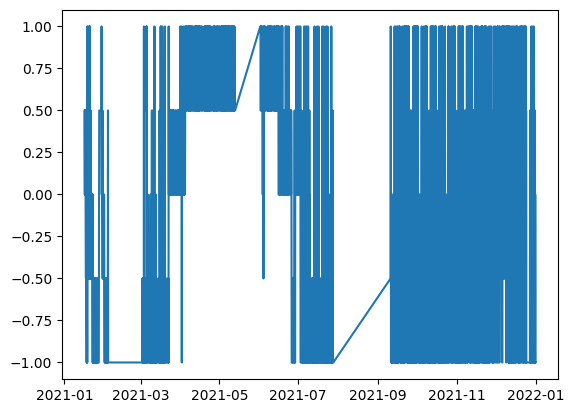

In [5]:
bd.index = pd.to_datetime(bd["record_date"], format="%Y-%m-%d %H:%M:00")
serie(bd,"incidents")
newBd = bd[["incidents","record_date"]]

<Axes: xlabel='record_date'>

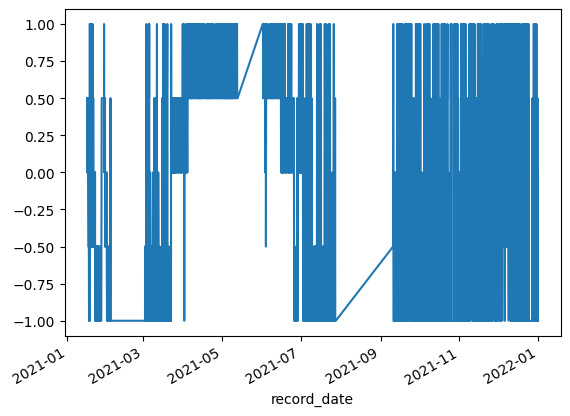

In [6]:
train, test = newBd[0:-600], newBd[-600:]
temp = bd["incidents"]
temp.plot()

In [7]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [8]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((4995, 5, 1), (4995,))

In [9]:
X_train1, y_train1 = X1[:4400], y1[:4400]
X_val1, y_val1 = X1[4400:4800], y1[4400:4800]
X_test1, y_test1 = X1[4800:], y1[4800:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((4400, 5, 1), (4400,), (400, 5, 1), (400,), (195, 5, 1), (195,))

In [10]:
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
 
filters=16
kernel_size=5
pool_size=2

#using the Functional API
inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE, 1))
#microarchitecture
x = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size,
activation='relu', data_format='channels_last')(inputs)
x = tf.keras.layers.AveragePooling1D(pool_size=pool_size,
data_format='channels_first')(x)
#last layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(filters)(x)
outputs = tf.keras.layers.Dense(1)(x)
#the model
cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_model')

In [11]:
cp1 = ModelCheckpoint('modelCNN', save_best_only=True)
cnnModel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [12]:
cnnModel.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
133/138 [===========================>..] - ETA: 0s - loss: 0.6241 - root_mean_squared_error: 0.7900

138/138 [==============================] - 16s 15ms/step - loss: 0.6215 - root_mean_squared_error: 0.7884 - val_loss: 0.6354 - val_root_mean_squared_error: 0.7971
Epoch 2/10
131/138 [===========================>..] - ETA: 0s - loss: 0.4887 - root_mean_squared_error: 0.6991

138/138 [==============================] - 2s 12ms/step - loss: 0.4876 - root_mean_squared_error: 0.6983 - val_loss: 0.5309 - val_root_mean_squared_error: 0.7286
Epoch 3/10
133/138 [===========================>..] - ETA: 0s - loss: 0.3698 - root_mean_squared_error: 0.6081

138/138 [==============================] - 1s 9ms/step - loss: 0.3695 - root_mean_squared_error: 0.6078 - val_loss: 0.4605 - val_root_mean_squared_error: 0.6786
Epoch 4/10
125/138 [==========================>...] - ETA: 0s - loss: 0.2880 - root_mean_squared_error: 0.5367

138/138 [==============================] - 1s 9ms/step - loss: 0.2842 - root_mean_squared_error: 0.5331 - val_loss: 0.4307 - val_root_mean_squared_error: 0.6562
Epoch 5/10
129/138 [===========================>..] - ETA: 0s - loss: 0.2364 - root_mean_squared_error: 0.4862

138/138 [==============================] - 1s 9ms/step - loss: 0.2371 - root_mean_squared_error: 0.4870 - val_loss: 0.4239 - val_root_mean_squared_error: 0.6510
Epoch 6/10
129/138 [===========================>..] - ETA: 0s - loss: 0.2147 - root_mean_squared_error: 0.4634

138/138 [==============================] - 1s 9ms/step - loss: 0.2163 - root_mean_squared_error: 0.4651 - val_loss: 0.4204 - val_root_mean_squared_error: 0.6484
Epoch 7/10
131/138 [===========================>..] - ETA: 0s - loss: 0.2073 - root_mean_squared_error: 0.4553

138/138 [==============================] - 1s 9ms/step - loss: 0.2070 - root_mean_squared_error: 0.4550 - val_loss: 0.4140 - val_root_mean_squared_error: 0.6435
Epoch 8/10
128/138 [==========================>...] - ETA: 0s - loss: 0.2057 - root_mean_squared_error: 0.4535

138/138 [==============================] - 1s 9ms/step - loss: 0.2014 - root_mean_squared_error: 0.4488 - val_loss: 0.4052 - val_root_mean_squared_error: 0.6366
Epoch 9/10
130/138 [===========================>..] - ETA: 0s - loss: 0.1978 - root_mean_squared_error: 0.4447

138/138 [==============================] - 1s 11ms/step - loss: 0.1970 - root_mean_squared_error: 0.4439 - val_loss: 0.3967 - val_root_mean_squared_error: 0.6298
Epoch 10/10
129/138 [===========================>..] - ETA: 0s - loss: 0.1916 - root_mean_squared_error: 0.4377

138/138 [==============================] - 1s 9ms/step - loss: 0.1933 - root_mean_squared_error: 0.4396 - val_loss: 0.3878 - val_root_mean_squared_error: 0.6227


In [13]:
from tensorflow.keras.models import load_model
model3 = load_model('modelCNN/')

In [14]:
train_predictions = model3.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

138/138 [==============================] - 0s 2ms/step


,Train Predictions,Actuals
0,0.250035,0.0
1,0.004796,0.0
2,0.028729,0.0
3,0.008897,0.5
4,0.250035,0.0
...,...,...
4395,-0.850899,-1.0
4396,-0.850899,-1.0
4397,-0.850899,-1.0
4398,-0.850899,-1.0


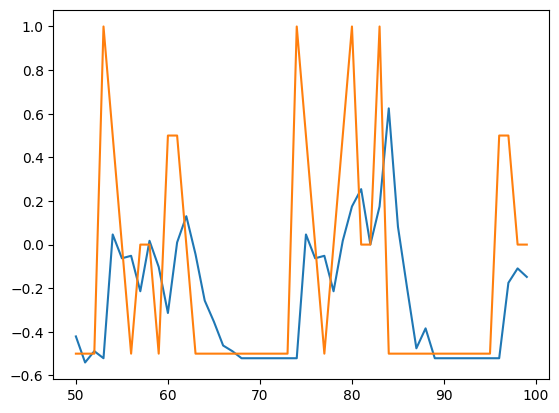

In [25]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [16]:
val_predictions = model3.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

13/13 [==============================] - 0s 2ms/step


,Val Predictions,Actuals
0,-0.850899,-1.0
1,-0.850899,-1.0
2,-0.850899,-1.0
3,-0.850899,-1.0
4,-0.850899,-1.0
...,...,...
395,-0.823345,-1.0
396,-0.850899,-1.0
397,-0.850899,-1.0
398,-0.850899,-1.0


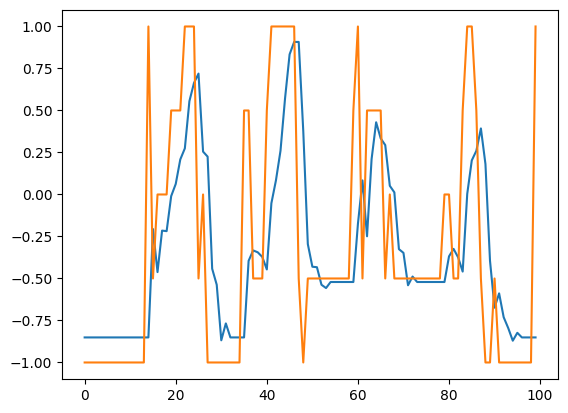

In [17]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [18]:
test_predictions = model3.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 [==============================] - 0s 5ms/step


,Test Predictions,Actuals
0,-0.850899,-1.0
1,-0.850899,0.5
2,-0.395041,-0.5
3,-0.512574,-0.5
4,-0.465077,-0.5
...,...,...
190,-0.649662,0.0
191,-0.434388,-1.0
192,-0.522876,-1.0
193,-0.715990,-1.0


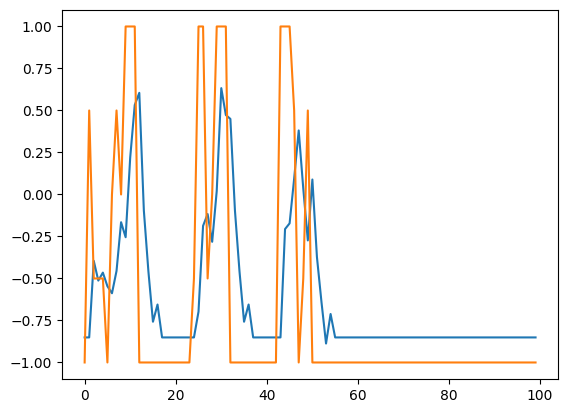

In [19]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [20]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

7/7 [==============================] - 0s 2ms/step


(     Predictions  Actuals
 0      -0.850899     -1.0
 1      -0.850899      0.5
 2      -0.395041     -0.5
 3      -0.512574     -0.5
 4      -0.465077     -0.5
 ..           ...      ...
 190    -0.649662      0.0
 191    -0.434388     -1.0
 192    -0.522876     -1.0
 193    -0.715990     -1.0
 194    -0.889821     -1.0
 
 [195 rows x 2 columns],
 0.3042950454257884)

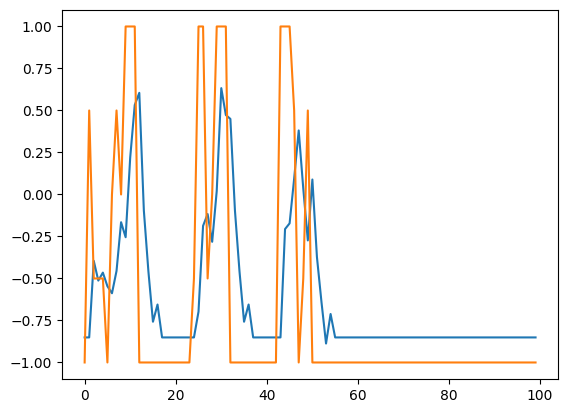

In [21]:
plot_predictions1(model3, X_test1, y_test1)

In [22]:
!zip -r /content/modelCNN.zip /content/modelCNN

  adding: content/modelCNN/ (stored 0%)
  adding: content/modelCNN/assets/ (stored 0%)
  adding: content/modelCNN/fingerprint.pb (stored 0%)
  adding: content/modelCNN/variables/ (stored 0%)
  adding: content/modelCNN/variables/variables.data-00000-of-00001 (deflated 52%)
  adding: content/modelCNN/variables/variables.index (deflated 60%)
  adding: content/modelCNN/keras_metadata.pb (deflated 88%)
  adding: content/modelCNN/saved_model.pb (deflated 87%)


In [28]:
from google.colab import files
files.download('CNN.ipynb')

FileNotFoundError: ignored